<a href="https://colab.research.google.com/github/kaifsakes/DEN/blob/Image-classifier-using-cnn/ITSOLERA_Skin_Cancer_Detection_Project_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/MyDrive/cancer data final/Skin_Cancer_Augmented.zip'
with ZipFile(file_path, 'r') as zip:
    zip.extractall()
    print('Done')

Done


In [5]:
image_dir = '/content/Skin_Cancer_Images'
csv_file = '/content/drive/MyDrive/cancer data final/skin_cancer_dataset_augmented.csv'

In [6]:
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=pd.read_csv(csv_file),
    directory=image_dir,
    x_col='isic_id',
    y_col='benign_malignant',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_dataframe(
    dataframe=pd.read_csv(csv_file),
    directory=image_dir,
    x_col='isic_id',
    y_col='benign_malignant',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 9600 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.


In [7]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
for layer in base_model.layers:
    layer.trainable = False

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

In [10]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=11,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/11


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 ━━━━━━━━━━━━━━━━━━━━ 2133s 7s/step - accuracy: 0.6054 - loss: 0.6648 - val_accuracy: 0.0037 - val_loss: 0.7784 - learning_rate: 0.0010
Epoch 2/11
300/300 ━━━━━━━━━━━━━━━━━━━━ 2104s 7s/step - accuracy: 0.6940 - loss: 0.5542 - val_accuracy: 0.9825 - val_loss: 0.5519 - learning_rate: 0.0010
Epoch 3/11
300/300 ━━━━━━━━━━━━━━━━━━━━ 2112s 7s/step - accuracy: 0.7569 - loss: 0.5003 - val_accuracy: 0.8092 - val_loss: 0.6527 - learning_rate: 0.0010
Epoch 4/11
300/300 ━━━━━━━━━━━━━━━━━━━━ 2137s 7s/step - accuracy: 0.7916 - loss: 0.4684 - val_accuracy: 0.9696 - val_loss: 0.5136 - learning_rate: 0.0010
Epoch 5/11
300/300 ━━━━━━━━━━━━━━━━━━━━ 2107s 7s/step - accuracy: 0.8120 - loss: 0.4424 - val_accuracy: 0.9671 - val_loss: 0.4953 - learning_rate: 0.0010
Epoch 6/11
300/300 ━━━━━━━━━━━━━━━━━━━━ 2120s 7s/step - accuracy: 0.8269 - loss: 0.4270 - val_accuracy: 0.9529 - val_loss: 0.5087 - learning_rate: 0.0010
Epoch 7/11
300/300 ━━━━━━━━━━━━━━━━━━━━ 2151s 7s/step - accuracy: 0.8311 - loss: 0.4184

In [ ]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc}")

90/90 ━━━━━━━━━━━━━━━━━━━━ 489s 5s/step - accuracy: 0.8914 - loss: 0.3326
Validation Accuracy: 0.8899018168449402


In [ ]:
y_pred_probs = model.predict(val_generator)
y_pred = (y_pred_probs > 0.5).astype(int)

90/90 ━━━━━━━━━━━━━━━━━━━━ 482s 5s/step


In [ ]:
cm = confusion_matrix(val_generator.classes, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[2513   24]
 [ 310    5]]


In [ ]:
cr = classification_report(val_generator.classes, y_pred, target_names=['benign', 'malignant'])
print("Classification Report:")
print(cr)

Classification Report:
              precision    recall  f1-score   support

      benign       0.89      0.99      0.94      2537
   malignant       0.17      0.02      0.03       315

    accuracy                           0.88      2852
   macro avg       0.53      0.50      0.48      2852
weighted avg       0.81      0.88      0.84      2852



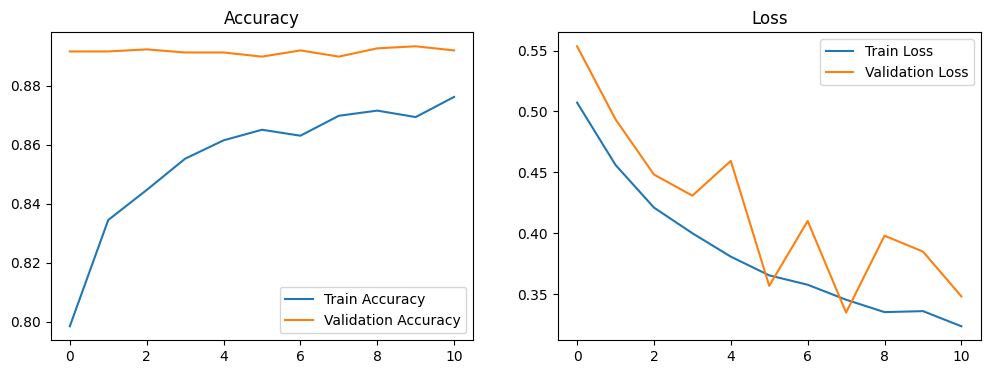

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [1]:
model_path = 'skin_cancer_detection_model.keras'
model.save(model_path)

NameError: name 'model' is not defined

In [ ]:
from google.colab import files
files.download('skin_cancer_detection_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>